# WATER BAG PREDICTION IN CATETE, RIO DE JANEIRO - MODEL SELECTION

#### Planning:
4. Evaluate on future test sample (6 months)
1. Model comparison
1. Grid search train_size, train_prct, n_estimators parameter for gbc and brfc models (with cross-validation).
2. Probability threshold score optimization for gbc and brfc models (with cross-validation).
3. Feature engineering

---
#### Change project root directory

In [3]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [4]:
import os, json, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time series transformation & binary classification pipeline

from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing and machine learning modules

from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr

from imblearn import ensemble
from imblearn.metrics import classification_report_imbalanced as cri

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Specific classification models

gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Metrics and scoring functions

from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


---
## Load & Preprocess Data

In [5]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
group_ts = project.time_serie
waterbags = project.waterbags

# Drop records before july, 2018
data = data['2018-06':]
group_ts = group_ts['2018-06':]

---

# Data Transformation

### Define feature dataset and target variables

#### Metheorological data after first registered waterbag event

In [9]:
top_grp = '13'
routes = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']
print(f'Train and test sets for water bag group: {routes[int(top_grp)]}. (Id: {top_grp})')

X = TimeseriesTransformPipeline(
    data, cut=-1, drop_empty_cols=True,
    scale=True, interpolate='nearest', fillna='min'
)

Y = group_ts[str(top_grp)].loc[X.index].copy()

groups = groupConsecutiveFlags(ts=Y)

display(Y.value_counts().to_frame('Class Count'))

Train and test sets for water bag group: Estrada da Cancela Preta. (Id: 13)
Initial data: (142867, 230)
Drop empty columns:  (142866, 217)


,Class Count
0.0,142602
1.0,264


---
# Cross validation split paramters

In [10]:
# Metrics
main_metrics = ['test_recall-0', 'test_recall-1', 'test_precision-1']
main_stats = ['mean', 'min', '50%', 'max']

# Split parameters
n_splits = 5
train_size = 0.7
test_size = 0.3
train_prct = None
test_prct = None

# Model parameters
seed = 3
n_estimators = 100

# Model
model = gbc(
    n_estimators=n_estimators, random_state=seed
#     validation_fraction=0.1,
#     n_iter_no_change=10, tol=1e-4
)

### Group K Fold Split
splitter = MinorityGroupSplitUndersample(
    n_splits,
    train_size, test_size, 
    train_prct, test_prct,
    random_state=seed
)

cv = list(splitter.split(
    X, Y, groups, strategy='GroupKFold'
)); print_cls_cnt(Y, cv[0][0], cv[0][1])

,Train set,Test set
Class,,
0.0,114513,28089
1.0,212,52


### Hyperparameter tunning

In [12]:
cv_base = list(splitter.split(
    X, Y, groups, strategy='GroupShuffleSplit',
)); print_cls_cnt(Y, cv[0][0], cv[0][1])

,Train set,Test set
Class,,
0.0,114513,28089
1.0,212,52


In [13]:
base_scr = pd.DataFrame(cross_validate(
    model, X, Y, cv=cv_base[:1],
    scoring=scoring,
    n_jobs=-1, verbose=5, error_score='raise'
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.4min finished


In [14]:
base_scr

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_recall-0,test_recall-1,test_precision-0,test_precision-1
0,235.073053,0.239678,0.998001,0.0,0.0,0.999849,0.0,0.998152,0.0


---
# Model Comparison - Estimator chain pipeline

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:
estimators = [('models', None)]
pipe = Pipeline(estimators)

param_grid = dict(
    models=[model, ], # LogisticRegression(), gbc(random_state=seed), SVC(),],
    models__n_estimators=range(10, 50, 10),
    models__max_depth=range(3, 9, 1),
#     models__subsample=[0.8, 1.0],
#     models__learning_rate=[.05, .1, .2],
)

grid_search = GridSearchCV(
    pipe, param_grid=param_grid, cv=cv,
    scoring=scoring, refit='precision-1',
    return_train_score=True,
    verbose=5, n_jobs=1
); grid_search.fit(X, Y)

pipe_scr = pd.DataFrame(grid_search.cv_results_)

#### Grid search results

In [15]:
pipe_scr[['param_models__n_estimators', 'mean_test_recall-1', 'mean_test_precision-1']]

NameError: name 'pipe_scr' is not defined

In [20]:
pipe_scr[['param_models__n_estimators', 'mean_test_recall-1', 'mean_test_precision-1']]

,param_models__n_estimators,mean_test_recall-1,mean_test_precision-1
0,5,0.418361,0.600286
1,10,0.388952,0.617525
2,15,0.383692,0.617396
3,20,0.387523,0.628123
4,30,0.383562,0.624342
5,45,0.389907,0.611682
6,60,0.397478,0.613431
7,75,0.398768,0.617342
8,90,0.394922,0.620894
9,105,0.394922,0.637931


#### Hyperparameter optimization

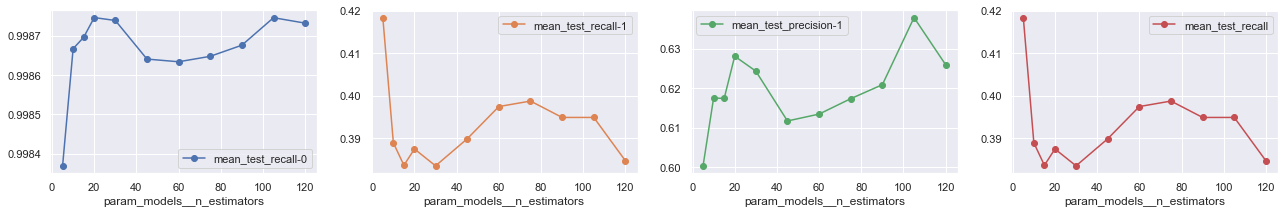

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(22, 3))
ax = pipe_scr.plot(
    'param_models__n_estimators',
    ['mean_test_recall-0', 'mean_test_recall-1', 'mean_test_precision-1', 'mean_test_recall', ],
    subplots=True, ax=ax, marker='o'
)

#### Selecting best estimator

In [22]:
grid_search.best_estimator_

Pipeline(steps=[('models',
                 GradientBoostingClassifier(n_estimators=105, random_state=3))])

In [23]:
grid_search.best_params_

{'models': GradientBoostingClassifier(n_estimators=105, random_state=3),
 'models__n_estimators': 105}

In [25]:
grid_search.best_score_

0.6379306515918934

# Train size optimization

In [159]:
from itertools import product

def make_grid(params):
    keys = list(params.keys())
    param_list = list(product(*[params[key] for key in keys]))
    return list(map(lambda param_tuple: {key: param for key, param in zip(keys, param_tuple)}, param_list))

split_params = dict(
    n_splits=25, # default 5 k folds
    train_size=.79, train_prct=1,
    test_size=.2, test_prct=None,
    random_state=0
)

In [159]:
def groupSplitScore(
    model, Xf, Y, groups,
    split_params={'train_size': 0.2},
    strategy='GroupShuffleSplit',
    scoring=scoring, verbose=5
):  
    splitter = MinorityGroupSplitUndersample(**split_params)
    cv = list(splitter.split(Xf, Y, groups, strategy))
    return pd.DataFrame(cross_validate(
        model, Xf, Y, cv=cv,
        scoring=scoring,
        verbose=verbose,
        n_jobs=-1
    ))    

def groupSplitGridSearch(
    model, Xf, Y,
    groups, split_grid,
    strategy='GroupShuffleSplit',
    scoring=scoring,
    verbose=5
):
    scrs = []
    param_grid = make_grid(split_grid)
    for i, split_params in enumerate(param_grid):
        co(wait=True); print(f'Param grid step: {i+1}/{len(param_grid)}')
        scr = groupSplitScore(
            model, Xf, Y, groups, split_params,
            strategy, scoring, verbose
        )
        for key, value in split_params.items(): scr[key] = value
        scrs.append(scr)
    return pd.concat(scrs)

In [ ]:
split_params = dict(
    n_splits=5, train_size=.79,
    train_prct=train_prct,
    test_size=.2, test_prct=None,
    random_state=0
)

scr = groupSplitScore(
    model, Xf, Y,
    groups, split_params,
    strategy='GroupShuffleSplit',
    scoring=scoring, verbose=5
)

In [274]:
train_size_i = np.linspace(0.15, 0.8**.5, 8) ** 2
train_prct_i = np.linspace(.1, 1, 10) ** 2 * 150

In [275]:
split_grid = dict(
    n_splits=[5],
    train_size=[.8], # train_size_i,
    train_prct=train_prct_i,
    test_size=[.2],
    test_prct=[181.8], # True negative/positive class proportion
    random_state=[0]
)

scr_grid = groupSplitGridSearch(
    model, Xf, Y,
    groups, split_grid,
    strategy='GroupKFold',
    scoring=scoring,
    verbose=5
)

Param grid step: 10/10


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.5s remaining:   32.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


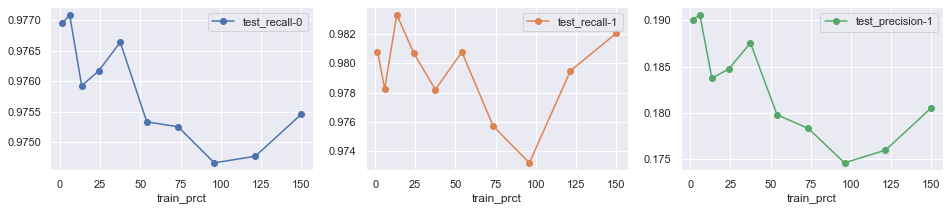

In [276]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
ax = scr_grid.groupby('train_prct')[main_metrics].mean().plot(subplots=True, marker='o', ax=ax)

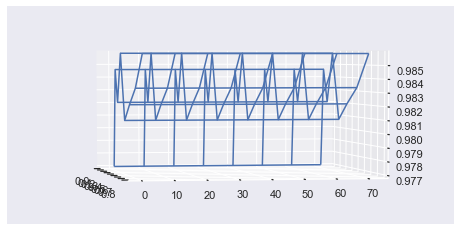

In [211]:
xx, yy = 'train_size', 'train_prct'
zz = 'test_recall-1'

scr_grid_grp = scr_grid.groupby([xx, yy], as_index=False).mean()

x, y = np.meshgrid(scr_grid_grp[xx].unique(), scr_grid_grp[yy].unique())
z = scr_grid_grp[zz].values.reshape(y.shape)

for angle in range(0, 360, 10):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(x, y, z)
    ax.view_init(3, angle)
    plt.show(); plt.pause(.1); co(wait=True)